In [7]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt # load plotting libraries
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from custom Python script
import regionmask

In [8]:
# Approximate the area of a spatial grid square from the latitudes and longitudes of the diagonal vertices
def area_latlon(lat1, lon1, lat2, lon2):
    # This function calculates the area (in km^2) of a spatial grid square, given the latitudes and longitudes of the two diagonal vertices of the grid square.
    # lat/lon is in angle; lat: [-90:90]; lon:[-180:180].
    # lat1/lon1 and lat2/lon2 are thus the diagonal vertices of the square grid.
    lat1 = lat1/180*np.pi
    lat2 = lat2/180*np.pi
    lon1 = lon1/180*np.pi
    lon2 = lon2/180*np.pi
    A = np.absolute(6371.009**2*(np.sin(lat2)-np.sin(lat1))*(lon2-lon1))
    return A

In [9]:
#convert annual mean kg/m2/s to kg/year
def unit_convert2(ds, varnames, res_lat, res_lon):
    for ivar in varnames:
        dr = ds[ivar]
        # use grid area function
        for ilat, lat in enumerate(dr.lat.values):
            area = 1e6 * area_latlon(lat1 = lat, lat2 = lat + res_lat,
                                     lon1 = 10, lon2 = 10 + res_lon) # m^2, longitude doesn't matter
            dr[ilat,:] = dr[ilat,:] * area * (3600*24*365) # kg/year
        ds[ivar] = dr.copy()
        ds[ivar].attrs['units'] = 'kg/year'
        ds[ivar].attrs['long_units'] = 'kg(' + ivar + ')/year'
    return ds

In [130]:
# get country total of a variable
def country_totals(co2_xarray, countries, varnames):
    # create masks using regionmask
    mask1 = regionmask.defined_regions.natural_earth.countries_50.mask(co2_xarray)
    # sum up total emissions for each country
    co2_countries = co2_xarray.groupby(mask1).sum('stacked_lat_lon')
    abbrevs = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].abbrevs
    names = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].names
    co2_countries.coords['abbrevs'] = ('region', abbrevs)
    co2_countries.coords['names'] = ('region', names)

    country_totals = np.zeros(len(countries))
    for i in range(len(countries)):
        tmp = co2_countries.isel(region=(co2_countries.names == countries[i]))
        country_totals[i] = tmp[varnames[0]].values
    return country_totals

In [132]:
# inputs
years = range(2011,2019,1)
res_lat = 0.25
res_lon = 0.3125
varnames = ['co2_ff']#, 'co2_bf', 'co_ff', 'co_bf', 'nox', 'ch4', 'nmvoc']
countries = ['Germany', 'United Kingdom']


CPU times: user 3.79 s, sys: 29.9 ms, total: 3.82 s
Wall time: 3.81 s


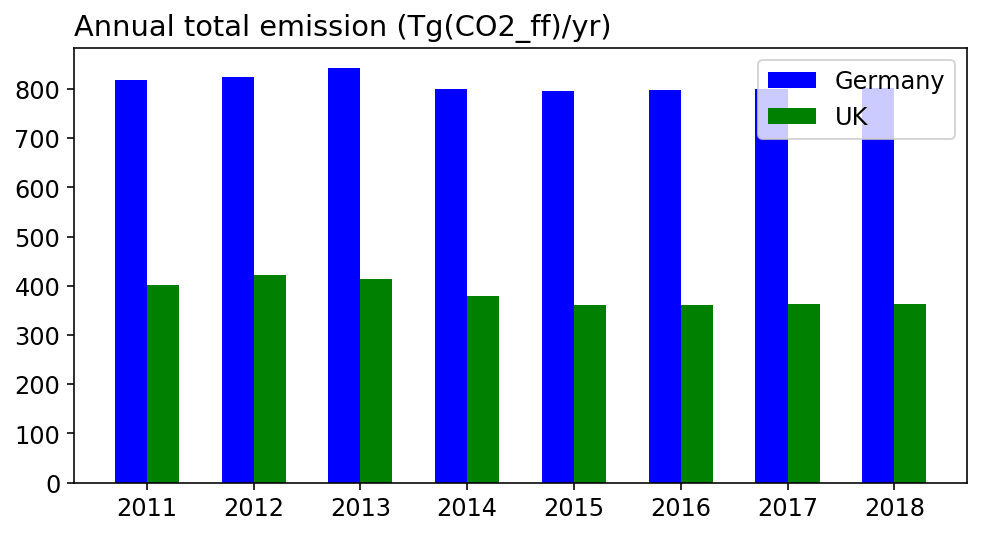

In [144]:
%%time
germany_emis = []
uk_emis = []

for iyear in years:
    fdir = '/geos/d21/msadiq/TNO-GHGco/gridded/'
    fname = 'TNO_' + str(iyear) + '_0.25x0.3125.nc'
    ds = xr.open_dataset(fdir + fname)
    
    ds_yearly = unit_convert2(ds, varnames, res_lat, res_lon)
    dr_yearly = ds_yearly[varnames]
    
    country_tmp = country_totals(dr_yearly, countries, varnames)
    germany_emis.append(country_tmp[0])
    uk_emis.append(country_tmp[1])
    
bar_pos = np.arange(len(years)) + 1 # position of the bars
fig = plt.figure(figsize=[8, 4])
width = 0.3
bars_germany = plt.bar(bar_pos-width*0.5, np.array(germany_emis)*1e-9, width=width, color = 'b', label='Germany')
bars_uk  = plt.bar(bar_pos+width*0.5, np.array(uk_emis)*1e-9, width=width, color = 'g', label='UK')
plt.xticks(bar_pos, years)
plt.title('Annual total emission (Tg(CO2_ff)/yr)', loc='left')
plt.legend()
